In [1]:
!python --version

Python 3.10.12


In [2]:
!git clone https://github.com/sheikhtajamul38/Adversarial-Collaborative-Filtering---RecSys.git

Cloning into 'Adversarial-Collaborative-Filtering---RecSys'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 43 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (43/43), 16.97 MiB | 5.27 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
import scipy.sparse as sp
import numpy as np

class Dataset(object):
    '''
    Loading the data file
        trainMatrix: load rating records as a sparse matrix for class Data
        trainList: load rating records as a list to speed up user's feature retrieval
        testRatings: load leave-one-out rating test for class Evaluate
        testNegatives: sample the items not rated by the user
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_training_file_as_matrix(path + ".train.rating")
        self.trainList = self.load_training_file_as_list(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        self.num_users, self.num_items = self.trainMatrix.shape

    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != "" and line is not None:
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList

    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != "" and line is not None:
                arr = line.split("\t")
                negatives = [int(x) for x in arr[1:]]
                negativeList.append(negatives)
                line = f.readline()
        return negativeList

    def load_training_file_as_matrix(self, filename):
        '''
        Read .rating file and return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get the number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != "" and line is not None:
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct the matrix
        mat = sp.dok_matrix((num_users + 1, num_items + 1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != "" and line is not None:
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if rating > 0:
                    mat[user, item] = 1.0
                line = f.readline()
        print("Already loaded the trainMatrix...")
        return mat

    def load_training_file_as_list(self, filename):
        # Get the number of users and items
        u_ = 0
        lists, items = [], []
        with open(filename, "r") as f:
            line = f.readline()
            index = 0
            while line != "" and line is not None:
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                if u_ < u:
                    index = 0
                    lists.append(items)
                    items = []
                    u_ += 1
                index += 1
                # if index < 300:
                items.append(i)
                line = f.readline()
        lists.append(items)
        print("Already loaded the trainList...")
        return lists


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from __future__ import absolute_import
from __future__ import division
import os
import math
import numpy as np
import tensorflow as tf
from multiprocessing import Pool
from multiprocessing import cpu_count
import argparse
import logging
from time import time
from time import strftime
from time import localtime

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
_user_input = None
_item_input_pos = None
_batch_size = None
_index = None
_model = None
_sess = None
_dataset = None
_K = None
_feed_dict = None
_output = None

In [5]:
def sampling(dataset):
    _user_input, _item_input_pos = [], []
    for (u, i) in list(dataset.trainMatrix.keys()):
        # positive instance
        _user_input.append(u)
        _item_input_pos.append(i)
    return _user_input, _item_input_pos

def shuffle(samples, batch_size, dataset, model):
    global _user_input
    global _item_input_pos
    global _batch_size
    global _index
    global _model
    global _dataset
    _user_input, _item_input_pos = samples
    _batch_size = batch_size
    _index = list(range(len(_user_input)))
    _model = model
    _dataset = dataset
    np.random.shuffle(_index)
    num_batch = len(_user_input) // _batch_size
    pool = Pool(cpu_count())
    res = pool.map(_get_train_batch, list(range(num_batch)))
    pool.close()
    pool.join()
    user_list = [r[0] for r in res]
    item_pos_list = [r[1] for r in res]
    user_dns_list = [r[2] for r in res]
    item_dns_list = [r[3] for r in res]
    return user_list, item_pos_list, user_dns_list, item_dns_list

def _get_train_batch(i):
    user_batch, item_batch = [], []
    user_neg_batch, item_neg_batch = [], []
    begin = i * _batch_size
    for idx in range(begin, begin + _batch_size):
        user_batch.append(_user_input[_index[idx]])
        item_batch.append(_item_input_pos[_index[idx]])
        for dns in range(_model.dns):
            user = _user_input[_index[idx]]
            user_neg_batch.append(user)
            # negative k
            gtItem = _dataset.testRatings[user][1]
            j = np.random.randint(_dataset.num_items)
            while j in _dataset.trainList[_user_input[_index[idx]]]:
                j = np.random.randint(_dataset.num_items)
            item_neg_batch.append(j)
    return np.array(user_batch)[:, None], np.array(item_batch)[:, None], \
           np.array(user_neg_batch)[:, None], np.array(item_neg_batch)[:, None]


In [6]:
class MF(tf.Module):
    def __init__(self, num_users, num_items, args):
        self.num_items = num_items
        self.num_users = num_users
        self.embedding_size = args.embed_size
        self.learning_rate = args.lr
        self.reg = args.reg
        self.dns = args.dns
        self.adv = args.adv
        self.eps = args.eps
        self.adver = args.adver
        self.reg_adv = args.reg_adv
        self.epochs = args.epochs

        self._create_placeholders()
        self._create_variables()
        self._create_loss()
        self._create_optimizer()
        self._create_adversarial()

    def _create_placeholders(self):
        self.user_input = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name="user_input")
        self.item_input_pos = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name="item_input_pos")
        self.item_input_neg = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name="item_input_neg")

    def _create_variables(self):
        self.embedding_P = tf.Variable(
            tf.random.truncated_normal([self.num_users, self.embedding_size], mean=0.0, stddev=0.01),
            name='embedding_P', dtype=tf.float32)  # (users, embedding_size)
        self.embedding_Q = tf.Variable(
            tf.random.truncated_normal([self.num_items, self.embedding_size], mean=0.0, stddev=0.01),
            name='embedding_Q', dtype=tf.float32)  # (items, embedding_size)

        self.delta_P = tf.Variable(tf.zeros([self.num_users, self.embedding_size]),
                                   name='delta_P', dtype=tf.float32, trainable=False)  # (users, embedding_size)
        self.delta_Q = tf.Variable(tf.zeros([self.num_items, self.embedding_size]),
                                   name='delta_Q', dtype=tf.float32, trainable=False)  # (items, embedding_size)

        self.h = tf.constant(1.0, tf.float32, [self.embedding_size, 1], name="h")

    def _create_inference(self, item_input):
        self.embedding_p = tf.reduce_sum(tf.nn.embedding_lookup(self.embedding_P, self.user_input), axis=1)
        self.embedding_q = tf.reduce_sum(tf.nn.embedding_lookup(self.embedding_Q, item_input), axis=1)  # (b, embedding_size)
        return tf.matmul(self.embedding_p * self.embedding_q, self.h), self.embedding_p, self.embedding_q

    def _create_inference_adv(self, item_input):
        self.embedding_p = tf.reduce_sum(tf.nn.embedding_lookup(self.embedding_P, self.user_input), axis=1)
        self.embedding_q = tf.reduce_sum(tf.nn.embedding_lookup(self.embedding_Q, item_input), axis=1)  # (b, embedding_size)
        self.P_plus_delta = self.embedding_p + tf.reduce_sum(tf.nn.embedding_lookup(self.delta_P, self.user_input), axis=1)
        self.Q_plus_delta = self.embedding_q + tf.reduce_sum(tf.nn.embedding_lookup(self.delta_Q, item_input), axis=1)
        return tf.matmul(self.P_plus_delta * self.Q_plus_delta, self.h), self.embedding_p, self.embedding_q

    def _create_loss(self):
        self.output, embed_p_pos, embed_q_pos = self._create_inference(self.item_input_pos)
        self.output_neg, embed_p_neg, embed_q_neg = self._create_inference(self.item_input_neg)
        self.result = tf.clip_by_value(self.output - self.output_neg, -80.0, 1e8)
        self.loss = tf.reduce_sum(tf.nn.softplus(-self.result))

        self.opt_loss = self.loss + self.reg * (
                tf.reduce_mean(tf.square(embed_p_pos) + tf.square(embed_q_pos) + tf.square(embed_q_neg)))

        if self.adv:
            self.output_adv, embed_p_pos, embed_q_pos = self._create_inference_adv(self.item_input_pos)
            self.output_neg_adv, embed_p_neg, embed_q_neg = self._create_inference_adv(self.item_input_neg)
            self.result_adv = tf.clip_by_value(self.output_adv - self.output_neg_adv, -80.0, 1e8)
            self.loss_adv = tf.reduce_sum(tf.nn.softplus(-self.result_adv))
            self.opt_loss += self.reg_adv * self.loss_adv + self.reg * (
                    tf.reduce_mean(tf.square(embed_p_pos) + tf.square(embed_q_pos) + tf.square(embed_q_neg)))

    def _create_adversarial(self):
        with tf.name_scope("adversarial"):
            if self.adv == "random":
                self.adv_P = tf.random.truncated_normal([self.num_users, self.embedding_size], mean=0.0, stddev=0.01)
                self.adv_Q = tf.random.truncated_normal([self.num_items, self.embedding_size], mean=0.0, stddev=0.01)
                self.update_P = self.delta_P.assign(tf.nn.l2_normalize(self.adv_P, axis=1) * self.eps)
                self.update_Q = self.delta_Q.assign(tf.nn.l2_normalize(self.adv_Q, axis=1) * self.eps)

            elif self.adv == "grad":
                self.grad_P, self.grad_Q = tf.gradients(self.loss, [self.embedding_P, self.embedding_Q])
                self.grad_P_dense = tf.stop_gradient(self.grad_P)
                self.grad_Q_dense = tf.stop_gradient(self.grad_Q)
                self.update_P = self.delta_P.assign(tf.nn.l2_normalize(self.grad_P_dense, axis=1) * self.eps)
                self.update_Q = self.delta_Q.assign(tf.nn.l2_normalize(self.grad_Q_dense, axis=1) * self.eps)

    def _create_optimizer(self):
        with tf.name_scope("optimizer"):
            # self.optimizer = tf.compat.v1.train.AdagradOptimizer(learning_rate=self.learning_rate).minimize(self.opt_loss)
            self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(self.opt_loss)

    def build_graph(self):
        self._create_placeholders()
        self._create_variables()
        self._create_loss()
        self._create_optimizer()
        self._create_adversarial()



In [7]:
def training(model, dataset, args, epoch_start, epoch_end, time_stamp):
    with tf.compat.v1.Session() as sess:
        # initialized the save op
        if args.adver:
            ckpt_save_path = "Pretrain/%s/APR/embed_%d/%s/" % (args.dataset, args.embed_size, time_stamp)
            ckpt_restore_path = "Pretrain/%s/MF_BPR/embed_%d/%s/" % (args.dataset, args.embed_size, time_stamp)
        else:
            ckpt_save_path = "Pretrain/%s/MF_BPR/embed_%d/%s/" % (args.dataset, args.embed_size, time_stamp)
            ckpt_restore_path = 0 if args.restore is None else "Pretrain/%s/MF_BPR/embed_%d/%s/" % (args.dataset, args.embed_size, args.restore)

        if not os.path.exists(ckpt_save_path):
            os.makedirs(ckpt_save_path)
        if ckpt_restore_path and not os.path.exists(ckpt_restore_path):
            os.makedirs(ckpt_restore_path)

        saver_ckpt = tf.compat.v1.train.Saver({'embedding_P': model.embedding_P, 'embedding_Q': model.embedding_Q})

        # pretrain or not
        sess.run(tf.compat.v1.global_variables_initializer())

        # restore the weights when pretrained
        if args.restore is not None or epoch_start:
            ckpt = tf.compat.v1.train.get_checkpoint_state(os.path.dirname(ckpt_restore_path + 'checkpoint'))
            if ckpt and ckpt.model_checkpoint_path:
                saver_ckpt.restore(sess, ckpt.model_checkpoint_path)
        # initialize the weights
        else:
            logging.info("Initialized from scratch")
            print("Initialized from scratch")

        # initialize for Evaluate
        eval_feed_dicts = init_eval_model(model, dataset)

        # sample the data
        samples = sampling(dataset)

        # initialize the max_ndcg to memorize the best result
        max_ndcg = 0
        best_res = {}
        ndcg_at_10_list = []
        ndcg_at_20_list = []
        recall_at_10_list = []
        recall_at_20_list = []

        # train by epoch
        for epoch_count in range(epoch_start, epoch_end + 1):

            # initialize for training batches
            batch_begin = time()
            batches = shuffle(samples, args.batch_size, dataset, model)
            batch_time = time() - batch_begin

            # compute the accuracy before training
            prev_batch = batches[0], batches[1], batches[3]
            _, prev_acc = training_loss_acc(model, sess, prev_batch, output_adv=0)

            # training the model
            train_begin = time()

            #train_batches = training_batch(model, sess, batches, args.adver)
            train_batches = training_batch(model, sess, batches, args.adver)

            train_time = time() - train_begin

            if epoch_count % args.verbose == 0:
                recall, ndcg, cur_res = output_evaluate(model, sess, dataset, train_batches, eval_feed_dicts,
                                                   epoch_count, batch_time, train_time, prev_acc, output_adv=0)
                ndcg_at_10_list.append(cur_res[1][9])  # NDCG for K=10
                ndcg_at_20_list.append(cur_res[1][19])  # NDCG for K=20
                recall_at_10_list.append(cur_res[0][9])  # Recall for K=10
                recall_at_20_list.append(cur_res[0][19])
                #print("Structure of cur_res:", cur_res)

            # print and log the best result
            if max_ndcg < ndcg:
                max_ndcg = ndcg
                best_res['result'] = cur_res
                best_res['epoch'] = epoch_count

            if model.epochs == epoch_count:
                print("Epoch %d is the best epoch" % best_res['epoch'])
                for idx, (recall_k, ndcg_k, auc_k) in enumerate(np.swapaxes(best_res['result'], 0, 1)):
                    res = "K = %d: Recall = %.4f, NDCG = %.4f AUC = %.4f" % (idx + 1, recall_k, ndcg_k, auc_k)
                    print(res)

            # save the embedding weights
            if args.ckpt > 0 and epoch_count % args.ckpt == 0:
                saver_ckpt.save(sess, ckpt_save_path + 'weights', global_step=epoch_count)
        import matplotlib.pyplot as plt

        """plt.figure(figsize=(12, 6))

        # Plot for NDCG@10 and NDCG@20
        plt.subplot(1, 2, 1)
        plt.plot(range(epoch_start, epoch_end + 1), ndcg_at_10_list, label='NDCG@10')
        plt.plot(range(epoch_start, epoch_end + 1), ndcg_at_20_list, label='NDCG@20', linestyle='--')
        plt.title('NDCG@K per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('NDCG@K')
        plt.legend()

        # Plot for Recall@10 and Recall@20
        plt.subplot(1, 2, 2)
        plt.plot(range(epoch_start, epoch_end + 1), recall_at_10_list, label='Recall@10')
        plt.plot(range(epoch_start, epoch_end + 1), recall_at_20_list, label='Recall@20', linestyle='--')
        plt.title('Recall@K per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Recall@K')
        plt.legend()

        plt.tight_layout()
        plt.show()"""


        saver_ckpt.save(sess, ckpt_save_path + 'weights', global_step=epoch_count)
        return ndcg_at_10_list, ndcg_at_20_list, recall_at_10_list, recall_at_20_list


In [8]:
def output_evaluate(model, sess, dataset, train_batches, eval_feed_dicts, epoch_count, batch_time, train_time, prev_acc,
                    output_adv):
    loss_begin = time()
    train_loss, post_acc = training_loss_acc(model, sess, train_batches, output_adv)
    loss_time = time() - loss_begin

    eval_begin = time()
    result = evaluate(model, sess, dataset, eval_feed_dicts, output_adv)
    eval_time = time() - eval_begin

    # check embedding
    embedding_P, embedding_Q = sess.run([model.embedding_P, model.embedding_Q])

    recall, ndcg, auc = np.swapaxes(result, 0, 1)[-1]
    res = "Epoch %d [%.1fs + %.1fs]: RECALL = %.4f, NDCG = %.4f ACC = %.4f ACC_adv = %.4f [%.1fs], |P|=%.2f, |Q|=%.2f" % \
          (epoch_count, batch_time, train_time, recall, ndcg, prev_acc,
           post_acc, eval_time, np.linalg.norm(embedding_P), np.linalg.norm(embedding_Q))

    print(res)

    return recall, ndcg, result

# input: batch_index (shuffled), model, sess, batches
# do: train the model optimizer
def training_batch(model, sess, batches, adver=False):
    user_input, item_input_pos, user_dns_list, item_dns_list = batches
    # dns for every mini-batch
    # dns = 1, i.e., BPR
    if model.dns == 1:
        item_input_neg = item_dns_list
        # for BPR training
        for i in range(len(user_input)):
            # Standard BPR or adversarial training
            feed_dict = {model.user_input: user_input[i],
                        model.item_input_pos: item_input_pos[i],
                        model.item_input_neg: item_input_neg[i]}
            sess.run(model.optimizer, feed_dict)

    # dns > 1, i.e., BPR-dns
    elif model.dns > 1:
        item_input_neg = []
        for i in range(len(user_input)):
            # get the output of negative sample
            feed_dict = {model.user_input: user_dns_list[i],
                         model.item_input_neg: item_dns_list[i]}
            output_neg = sess.run(model.output_neg, feed_dict)
            # select the best negative sample as for item_input_neg
            item_neg_batch = []
            for j in range(0, len(output_neg), model.dns):
                item_index = np.argmax(output_neg[j: j + model.dns])
                item_neg_batch.append(item_dns_list[i][j: j + model.dns][item_index][0])
            item_neg_batch = np.array(item_neg_batch)[:, None]
            # for mini-batch BPR training
            feed_dict = {model.user_input: user_input[i],
                         model.item_input_pos: item_input_pos[i],
                         model.item_input_neg: item_neg_batch}
            sess.run(model.optimizer, feed_dict)
            item_input_neg.append(item_neg_batch)
    return user_input, item_input_pos, item_input_neg

# calculate the gradients
# update the adversarial noise
def adv_update(model, sess, train_batches):
    user_input, item_input_pos, item_input_neg = train_batches
    # reshape mini-batches into a whole large batch
    user_input, item_input_pos, item_input_neg = \
        np.reshape(user_input, (-1, 1)), np.reshape(item_input_pos, (-1, 1)), np.reshape(item_input_neg, (-1, 1))
    feed_dict = {model.user_input: user_input,
                 model.item_input_pos: item_input_pos,
                 model.item_input_neg: item_input_neg}

    return sess.run([model.update_P, model.update_Q], feed_dict)

# input: model, sess, batches
# output: training_loss
def training_loss_acc(model, sess, train_batches, output_adv):
    train_loss = 0.0
    acc = 0
    num_batch = len(train_batches[1])
    user_input, item_input_pos, item_input_neg = train_batches
    for i in range(len(user_input)):
        # print user_input[i][0]. item_input_pos[i][0], item_input_neg[i][0]
        feed_dict = {model.user_input: user_input[i],
                     model.item_input_pos: item_input_pos[i],
                     model.item_input_neg: item_input_neg[i]}
        if output_adv:
            loss, output_pos, output_neg = sess.run([model.loss_adv, model.output_adv, model.output_neg_adv], feed_dict)
        else:
            loss, output_pos, output_neg = sess.run([model.loss, model.output, model.output_neg], feed_dict)
        train_loss += loss
        acc += ((output_pos - output_neg) > 0).sum() / len(output_pos)
    return train_loss / num_batch, acc / num_batch


In [9]:
def init_eval_model(model, dataset):
    begin_time = time()
    global _dataset
    global _model
    _dataset = dataset
    _model = model

    pool = Pool(cpu_count())
    feed_dicts = pool.map(_evaluate_input, range(_dataset.num_users))
    pool.close()
    pool.join()

    print("Load the evaluation model done [%.1f s]" % (time() - begin_time))
    return feed_dicts

def _evaluate_input(user):
    # generate items_list
    test_item = _dataset.testRatings[user][1]

    # test_item = _dataset.testNegatives[user][1]
    item_input = set(range(_dataset.num_items)) - set(_dataset.trainList[user])
    if test_item in item_input:
        item_input.remove(test_item)
    item_input = list(item_input)
    item_input.append(test_item)
    user_input = np.full(len(item_input), user, dtype='int32')[:, None]
    item_input = np.array(item_input)[:, None]
    return user_input, item_input

def evaluate(model, sess, dataset, feed_dicts, output_adv):
    global _model
    global _K
    global _sess
    global _dataset
    global _feed_dicts
    global _output
    _dataset = dataset
    _model = model
    _sess = sess
    _K = 20
    _feed_dicts = feed_dicts
    _output = output_adv

    res = []
    for user in range(_dataset.num_users):
        res.append(_eval_by_user(user))
    res = np.array(res)
    recall, ndcg, auc = (res.mean(axis=0)).tolist()

    return recall, ndcg, auc

def _eval_by_user(user):
    # get predictions of data in the testing set
    user_input, item_input = _feed_dicts[user]
    feed_dict = {_model.user_input: user_input, _model.item_input_pos: item_input}
    if _output:
        predictions = _sess.run(_model.output_adv, feed_dict)
    else:
        predictions = _sess.run(_model.output, feed_dict)

    neg_predict, pos_predict = predictions[:-1], predictions[-1]
    position = (neg_predict >= pos_predict).sum()

    # calculate from Recall@1 to Recall@100, and from NDCG@1 to NDCG@100, AUC
    recall, ndcg, auc = [], [], []
    for k in range(1, _K + 1):
        recall.append(position < k)
        ndcg.append(math.log(2) / math.log(position + 2) if position < k else 0)
        auc.append(1 - (position / len(neg_predict)))  # formula: [#(Xui>Xuj) / #(Items)] = [1 - #(Xui<=Xuj) / #(Items)]

    return recall, ndcg, auc

def init_logging(args, time_stamp):
    path = "Log/%s_%s/" % (strftime('%Y-%m-%d_%H', localtime()), args.task)
    if not os.path.exists(path):
        os.makedirs(path)
    logging.basicConfig(filename=path + "%s_log_embed_size%d_%s" % (args.dataset, args.embed_size, time_stamp),
                        level=logging.INFO)
    logging.info(args)
    print(args)


In [18]:
def set_args():
    args = argparse.Namespace()
    args.path = '/content/Adversarial-Collaborative-Filtering---RecSys/Data/'
    args.dataset = 'yelp'
    args.verbose = 1
    args.batch_size = 1024
    args.epochs = 100
    args.embed_size = 128
    args.dns = 1
    args.reg = 0
    args.lr = 0.05
    args.reg_adv = 1
    args.restore = None
    args.ckpt = 5
    args.task = ''
    args.adv_epoch = 40
    args.adv = 'grad'
    args.eps = 0.5

    return args


def parse_args():
    parser = argparse.ArgumentParser(description="Run AMF.")
    parser.add_argument('--path', nargs='?', default='Data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='yelp',
                        help='Choose a dataset.')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Evaluate per X epochs.')
    parser.add_argument('--batch_size', type=int, default=512,
                        help='batch_size')
    parser.add_argument('--epochs', type=int, default=2000,
                        help='Number of epochs.')
    parser.add_argument('--embed_size', type=int, default=64,
                        help='Embedding size.')
    parser.add_argument('--dns', type=int, default=1,
                        help='number of negative sample for each positive in dns.')
    parser.add_argument('--reg', type=float, default=0,
                        help='Regularization for user and item embeddings.')
    parser.add_argument('--lr', type=float, default=0.05,
                        help='Learning rate.')
    parser.add_argument('--reg_adv', type=float, default=1,
                        help='Regularization for adversarial loss')
    parser.add_argument('--restore', type=str, default=None,
                        help='The restore time_stamp for weights in \Pretrain')
    parser.add_argument('--ckpt', type=int, default=100,
                        help='Save the model per X epochs.')
    parser.add_argument('--task', nargs='?', default='',
                        help='Add the task name for launching experiments')
    parser.add_argument('--adv_epoch', type=int, default=0,
                        help='Add APR in epoch X, when adv_epoch is 0, it\'s equivalent to pure AMF.\n '
                             'And when adv_epoch is larger than epochs, it\'s equivalent to pure MF model. ')
    parser.add_argument('--adv', nargs='?', default='grad',
                        help='Generate the adversarial sample by gradient method or random method')
    parser.add_argument('--eps', type=float, default=0.5,
                        help='Epsilon for adversarial weights.')
    return parser.parse_args()

In [19]:
tf.compat.v1.disable_eager_execution()

In [20]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [23]:
# Initialize a time stamp
time_stamp = strftime('%Y_%m_%d_%H_%M_%S', localtime())

# Initialize arguments and logging
args = set_args()

init_logging(args, time_stamp)

args.path = '/kaggle/working/Adversarial-Collaborative-Filtering---RecSys/Data/'

# Initialize the dataset
dataset = Dataset(args.path + args.dataset)

# Set args.adver to 0
args.adver = 0

# Initialize MF_BPR models
MF_BPR = MF(dataset.num_users, dataset.num_items, args)
MF_BPR.build_graph()

print("Initialize MF_BPR")

# Start training
#training(MF_BPR, dataset, args, epoch_start=0, epoch_end=args.adv_epoch-1, time_stamp=time_stamp)
ndcg_at_10_bpr, ndcg_at_20_bpr, recall_at_10_bpr, recall_at_20_bpr = training(MF_BPR, dataset, args, epoch_start=0, epoch_end=args.adv_epoch-1, time_stamp=time_stamp)
# Set args.adver to 1
args.adver = 1

# Initialize AMF model
AMF = MF(dataset.num_users, dataset.num_items, args)
AMF.build_graph()

print("Initialize AMF")

# Start training
#training(AMF, dataset, args, epoch_start=args.adv_epoch, epoch_end=args.epochs, time_stamp=time_stamp)
ndcg_at_10_amf, ndcg_at_20_amf, recall_at_10_amf, recall_at_20_amf = training(AMF, dataset, args, epoch_start=args.adv_epoch, epoch_end=args.epochs, time_stamp=time_stamp)


Namespace(path='/content/Adversarial-Collaborative-Filtering---RecSys/Data/', dataset='yelp', verbose=1, batch_size=1024, epochs=100, embed_size=128, dns=1, reg=0, lr=0.05, reg_adv=1, restore=None, ckpt=5, task='', adv_epoch=40, adv='grad', eps=0.5)
Already loaded the trainMatrix...
Already loaded the trainList...
Initialize MF_BPR
Initialized from scratch
Load the evaluation model done [60.6 s]
Epoch 0 [3.5s + 2.0s]: RECALL = 0.0298, NDCG = 0.0101 ACC = 0.4999 ACC_adv = 0.9460 [34.0s], |P|=19.28, |Q|=19.42
Epoch 1 [3.7s + 1.8s]: RECALL = 0.0392, NDCG = 0.0123 ACC = 0.8790 ACC_adv = 0.9157 [34.1s], |P|=98.56, |Q|=99.30
Epoch 2 [3.8s + 1.8s]: RECALL = 0.0257, NDCG = 0.0090 ACC = 0.9047 ACC_adv = 0.9329 [33.6s], |P|=161.00, |Q|=163.66
Epoch 3 [3.5s + 1.9s]: RECALL = 0.0233, NDCG = 0.0081 ACC = 0.9231 ACC_adv = 0.9420 [34.4s], |P|=197.33, |Q|=201.97
Epoch 4 [3.6s + 1.8s]: RECALL = 0.0259, NDCG = 0.0084 ACC = 0.9298 ACC_adv = 0.9484 [33.5s], |P|=222.01, |Q|=228.63
Epoch 5 [3.5s + 1.8s]: RE

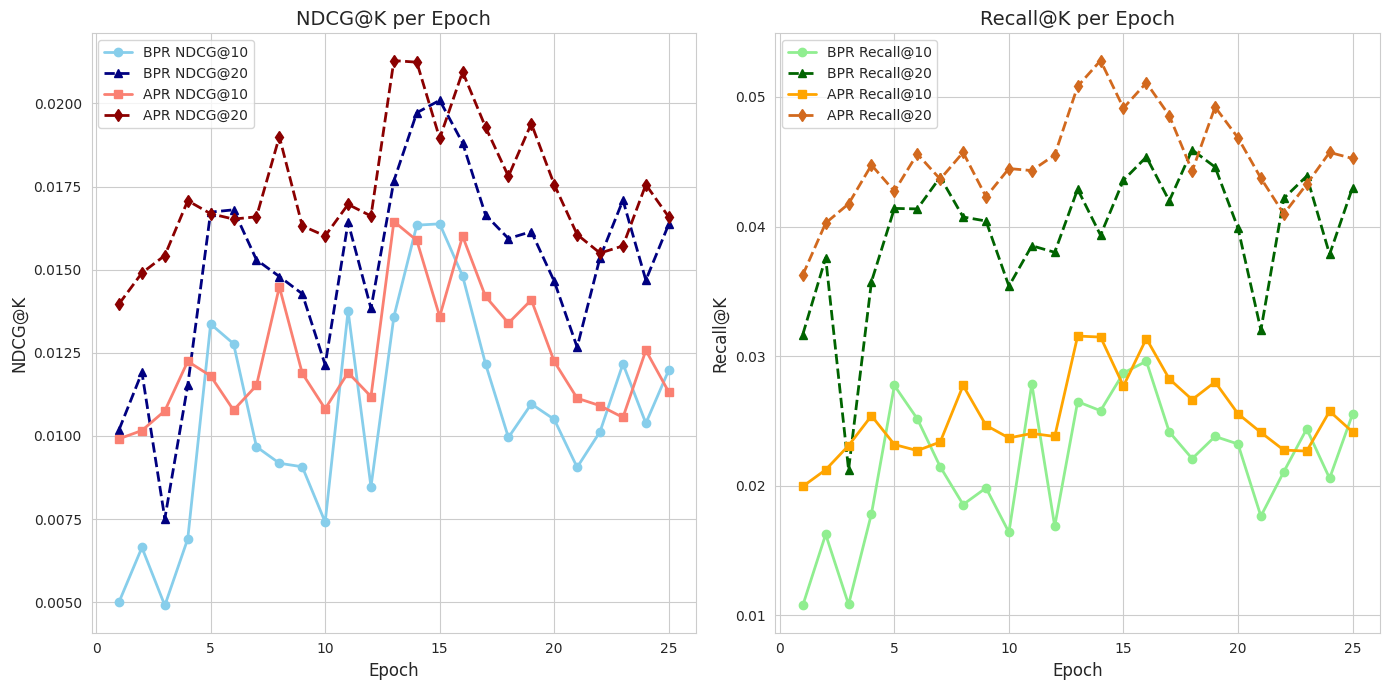

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

shortest_length = min(len(ndcg_at_10_bpr), len(ndcg_at_20_bpr), len(ndcg_at_10_amf), len(ndcg_at_20_amf), len(recall_at_10_bpr), len(recall_at_20_bpr), len(recall_at_10_amf), len(recall_at_20_amf))
epochs = range(1, shortest_length + 1)

# Trim the arrays to the shortest length
ndcg_at_10_bpr = ndcg_at_10_bpr[:shortest_length]
ndcg_at_20_bpr = ndcg_at_20_bpr[:shortest_length]
ndcg_at_10_amf = ndcg_at_10_amf[:shortest_length]
ndcg_at_20_amf = ndcg_at_20_amf[:shortest_length]
recall_at_10_bpr = recall_at_10_bpr[:shortest_length]
recall_at_20_bpr = recall_at_20_bpr[:shortest_length]
recall_at_10_amf = recall_at_10_amf[:shortest_length]
recall_at_20_amf = recall_at_20_amf[:shortest_length]

plt.figure(figsize=(14, 7))

# NDCG Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, ndcg_at_10_bpr, label='BPR NDCG@10', color='skyblue', linewidth=2, marker='o')
plt.plot(epochs, ndcg_at_20_bpr, label='BPR NDCG@20', color='navy', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs, ndcg_at_10_amf, label='APR NDCG@10', color='salmon', linewidth=2, marker='s')
plt.plot(epochs, ndcg_at_20_amf, label='APR NDCG@20', color='darkred', linestyle='--', linewidth=2, marker='d')
plt.title('NDCG@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('NDCG@K', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Recall Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, recall_at_10_bpr, label='BPR Recall@10', color='lightgreen', linewidth=2, marker='o')
plt.plot(epochs, recall_at_20_bpr, label='BPR Recall@20', color='darkgreen', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs, recall_at_10_amf, label='APR Recall@10', color='orange', linewidth=2, marker='s')
plt.plot(epochs, recall_at_20_amf, label='APR Recall@20', color='chocolate', linestyle='--', linewidth=2, marker='d')
plt.title('Recall@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall@K', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [25]:
len(ndcg_at_10_bpr), len(ndcg_at_20_bpr), len(ndcg_at_10_amf), len(ndcg_at_20_amf), len(recall_at_10_bpr), len(recall_at_20_bpr), len(recall_at_10_amf), len(recall_at_20_amf)


(40, 40, 61, 61, 40, 40, 61, 61)

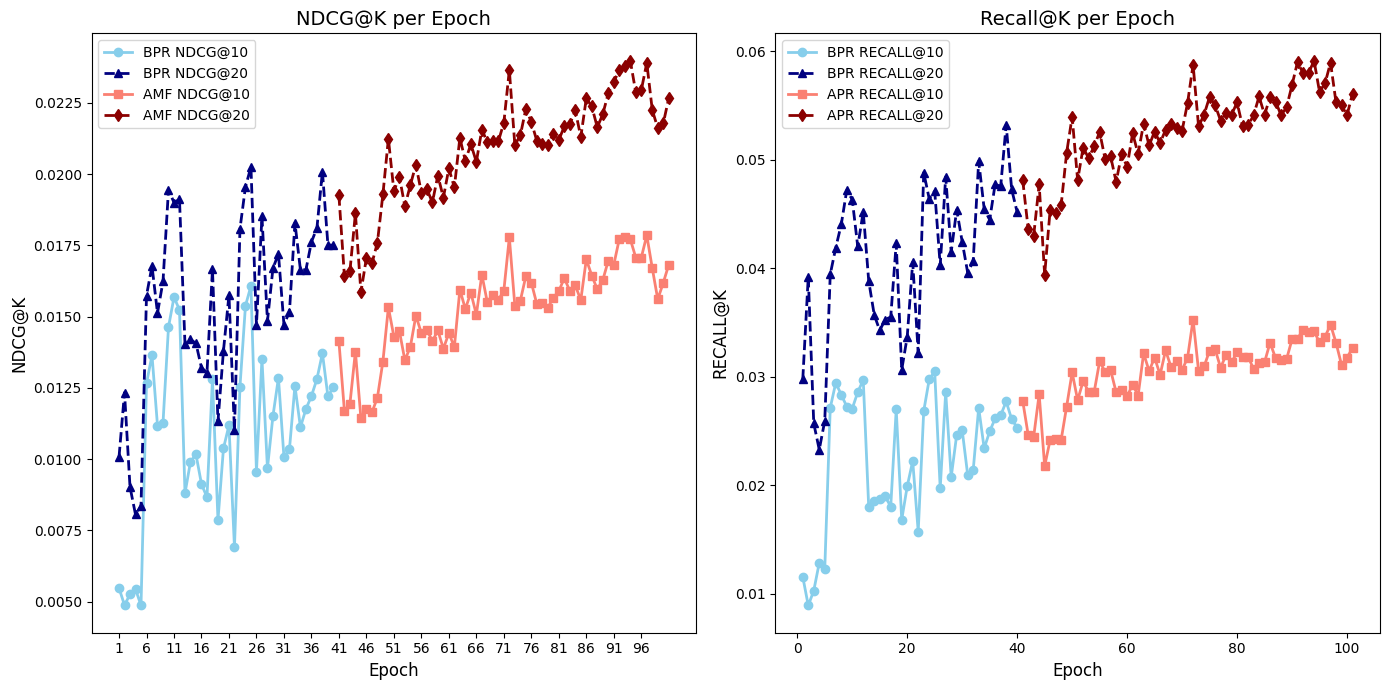

In [31]:
import matplotlib.pyplot as plt

epochs_bpr = range(1, len(ndcg_at_20_bpr)+1)  # BPR epochs from 1 to 25
epochs_amf = range(len(ndcg_at_20_bpr)+1, len(ndcg_at_20_bpr)+1+len(ndcg_at_10_amf))  # AMF epochs from 26 to 50
# BPR part
plt.figure(figsize=(14, 7))

# NDCG Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_bpr, ndcg_at_10_bpr, label='BPR NDCG@10', color='skyblue', linewidth=2, marker='o')
plt.plot(epochs_bpr, ndcg_at_20_bpr, label='BPR NDCG@20', color='navy', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs_amf, ndcg_at_10_amf, label='AMF NDCG@10', color='salmon', linewidth=2, marker='s')
plt.plot(epochs_amf, ndcg_at_20_amf, label='AMF NDCG@20', color='darkred', linestyle='--', linewidth=2, marker='d')
plt.title('NDCG@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('NDCG@K', fontsize=12)
plt.legend(loc='upper left')

# Set x-axis ticks to be more readable
plt.xticks(range(1, 101, 5))  # Show every 5th epoch number on the x-axis

plt.yticks(fontsize=10)

# Recall Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_bpr, recall_at_10_bpr, label='BPR RECALL@10', color='skyblue', linewidth=2, marker='o')
plt.plot(epochs_bpr, recall_at_20_bpr, label='BPR RECALL@20', color='navy', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs_amf, recall_at_10_amf, label='APR RECALL@10', color='salmon', linewidth=2, marker='s')
plt.plot(epochs_amf, recall_at_20_amf, label='APR RECALL@20', color='darkred', linestyle='--', linewidth=2, marker='d')
plt.title('Recall@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RECALL@K', fontsize=12)
plt.legend(loc='upper left')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# MovieLens 1M

In [32]:
def set_args():
    args = argparse.Namespace()
    args.path = '/content/adversarial_personalized_ranking/Data/'
    args.dataset = 'ml-1m'
    args.verbose = 1
    args.batch_size = 1024
    args.epochs = 100
    args.embed_size = 128
    args.dns = 1
    args.reg = 0
    args.lr = 0.05
    args.reg_adv = 1
    args.restore = None
    args.ckpt = 5
    args.task = ''
    args.adv_epoch = 30
    args.adv = 'grad'
    args.eps = 0.5

    return args

In [33]:
# Initialize a time stamp
time_stamp = strftime('%Y_%m_%d_%H_%M_%S', localtime())


# Initialize arguments and logging
args = set_args()

init_logging(args, time_stamp)

args.path = '/kaggle/working/adversarial_personalized_ranking/Data/'


# Initialize the dataset
dataset = Dataset(args.path + args.dataset)

# Set args.adver to 0
args.adver = 0

# Initialize MF_BPR models
MF_BPR = MF(dataset.num_users, dataset.num_items, args)
MF_BPR.build_graph()

print("Initialize MF_BPR")

# Start training
#training(MF_BPR, dataset, args, epoch_start=0, epoch_end=args.adv_epoch-1, time_stamp=time_stamp)
ndcg_at_10_bpr, ndcg_at_20_bpr, recall_at_10_bpr, recall_at_20_bpr = training(MF_BPR, dataset, args, epoch_start=0, epoch_end=args.adv_epoch-1, time_stamp=time_stamp)
# Set args.adver to 1
args.adver = 1

# Initialize AMF model
AMF = MF(dataset.num_users, dataset.num_items, args)
AMF.build_graph()

print("Initialize AMF")
#training(AMF, dataset, args, epoch_start=args.adv_epoch, epoch_end=args.epochs, time_stamp=time_stamp)
ndcg_at_10_amf, ndcg_at_20_amf, recall_at_10_amf, recall_at_20_amf = training(AMF, dataset, args, epoch_start=args.adv_epoch, epoch_end=args.epochs, time_stamp=time_stamp)


Namespace(path='/content/adversarial_personalized_ranking/Data/', dataset='ml-1m', verbose=1, batch_size=1024, epochs=100, embed_size=128, dns=1, reg=0, lr=0.05, reg_adv=1, restore=None, ckpt=5, task='', adv_epoch=30, adv='grad', eps=0.5)
Already loaded the trainMatrix...
Already loaded the trainList...
Initialize MF_BPR
Initialized from scratch
Load the evaluation model done [3.8 s]
Epoch 0 [7.6s + 3.2s]: RECALL = 0.0704, NDCG = 0.0280 ACC = 0.5002 ACC_adv = 0.8770 [6.0s], |P|=90.95, |Q|=93.71
Epoch 1 [8.0s + 3.1s]: RECALL = 0.0869, NDCG = 0.0343 ACC = 0.8724 ACC_adv = 0.9192 [5.7s], |P|=125.64, |Q|=129.46
Epoch 2 [7.9s + 3.0s]: RECALL = 0.0947, NDCG = 0.0390 ACC = 0.9077 ACC_adv = 0.9378 [5.5s], |P|=149.91, |Q|=153.12
Epoch 3 [8.2s + 3.0s]: RECALL = 0.1162, NDCG = 0.0439 ACC = 0.9200 ACC_adv = 0.9527 [5.8s], |P|=171.41, |Q|=173.69
Epoch 4 [7.8s + 3.0s]: RECALL = 0.1190, NDCG = 0.0451 ACC = 0.9290 ACC_adv = 0.9659 [5.8s], |P|=193.34, |Q|=195.04
Epoch 5 [7.8s + 3.0s]: RECALL = 0.1171, 

In [39]:
len(ndcg_at_10_bpr), len(ndcg_at_20_bpr), len(recall_at_10_bpr), len(recall_at_20_bpr),len(ndcg_at_10_amf), len(ndcg_at_20_amf), len(recall_at_10_amf), len(recall_at_20_amf)

(30, 30, 30, 30, 71, 71, 71, 71)

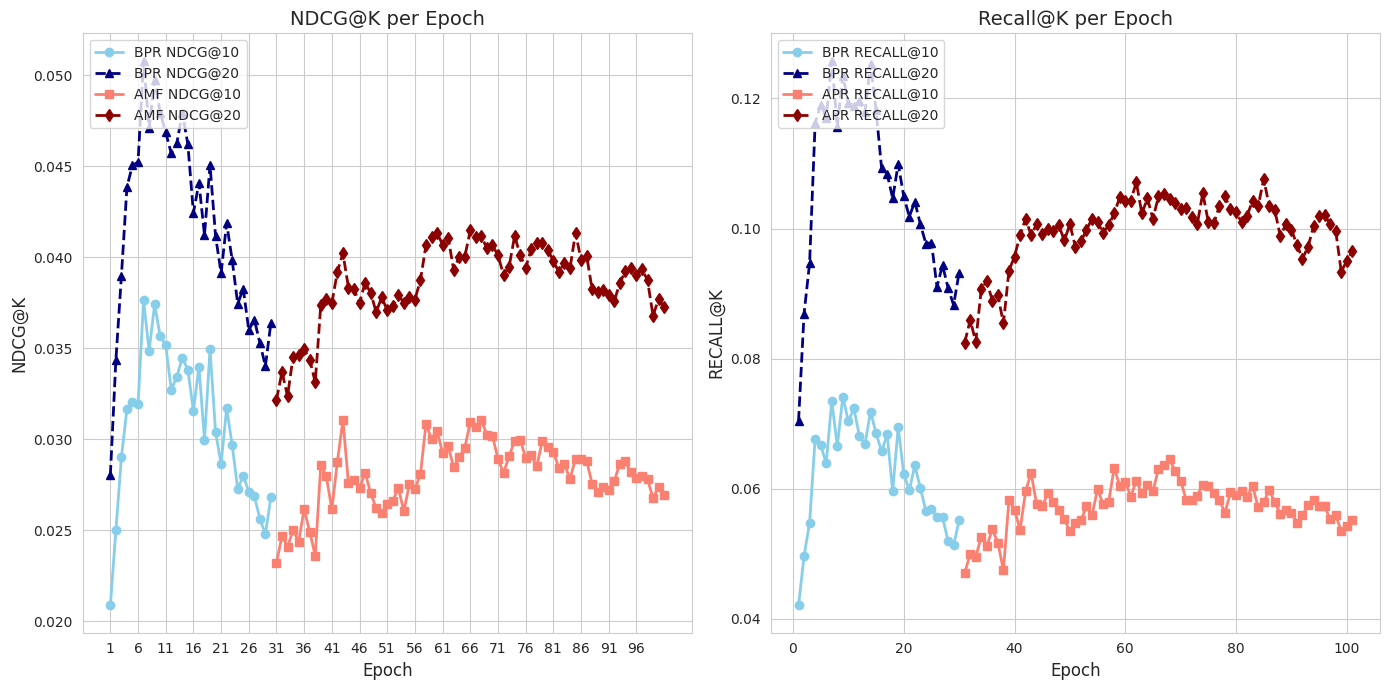

In [44]:
epochs_bpr = range(1, len(ndcg_at_20_bpr)+1)  # BPR epochs from 1 to 25
epochs_amf = range(len(ndcg_at_20_bpr)+1, len(ndcg_at_20_bpr)+1+len(ndcg_at_10_amf))  # AMF epochs from 26 to 50
# BPR part
plt.figure(figsize=(14, 7))

# NDCG Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_bpr, ndcg_at_10_bpr, label='BPR NDCG@10', color='skyblue', linewidth=2, marker='o')
plt.plot(epochs_bpr, ndcg_at_20_bpr, label='BPR NDCG@20', color='navy', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs_amf, ndcg_at_10_amf, label='AMF NDCG@10', color='salmon', linewidth=2, marker='s')
plt.plot(epochs_amf, ndcg_at_20_amf, label='AMF NDCG@20', color='darkred', linestyle='--', linewidth=2, marker='d')
plt.title('NDCG@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('NDCG@K', fontsize=12)
plt.legend(loc='upper left')

# Set x-axis ticks to be more readable
plt.xticks(range(1, 101, 5))  # Show every 5th epoch number on the x-axis

plt.yticks(fontsize=10)

# Recall Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_bpr, recall_at_10_bpr, label='BPR RECALL@10', color='skyblue', linewidth=2, marker='o')
plt.plot(epochs_bpr, recall_at_20_bpr, label='BPR RECALL@20', color='navy', linestyle='--', linewidth=2, marker='^')
plt.plot(epochs_amf, recall_at_10_amf, label='APR RECALL@10', color='salmon', linewidth=2, marker='s')
plt.plot(epochs_amf, recall_at_20_amf, label='APR RECALL@20', color='darkred', linestyle='--', linewidth=2, marker='d')
plt.title('Recall@K per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RECALL@K', fontsize=12)
plt.legend(loc='upper left')


# Adjust layout and show the plot
plt.tight_layout()
plt.show()